In [2]:
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
import time
import os


In [ ]:
# get current directory
WORK_DIR = os.getcwd()
print("Working directory:", WORK_DIR)

Working directory: /home/ubuntu/power-consumption-tool/power-metrics-per-pod-realtime


'/home/ubuntu/power-consumption-tool/power-metrics-per-pod-realtime'

In [ ]:

# Prometheus server URL
PROMETHEUS_URL = "http://192.169.122.115:32236"
# Prometheus query to fetch the metric in watts if greater than 0.01
QUERY = 'scaph_process_power_consumption_microwatts{container_scheduler="docker"} / 1000000 > 0.01'
SAVE_FILE_PATH_DATA = f"{WORK_DIR}/data/pc-time-containers.json"
SAVE_FILE_PATH_PLOT = f"{WORK_DIR}/figures/pc-time-containers.png"
POD_DATA=f"{WORK_DIR}/data/all_pod_metrics.json"
search_term = 'oai-upf'  # Change this to your search term
ip_address = '12.1.1.100'  # Change this to your target IP address
value = '80'  # iperf MB bandwidth


In [5]:
def fetch_metrics():
    """Fetches metrics from Prometheus and returns a dictionary of values by container ID."""
    response = requests.get(f"{PROMETHEUS_URL}/api/v1/query", params={'query': QUERY})
    metrics_by_container = {}

    if response.status_code == 200:
        try:
            result = response.json()
            for entry in result['data']['result']:
                # Extract container_id and metric value
                container_id = entry['metric'].get('container_id', 'unknown')
                value = float(entry['value'][1])
                cmdline= entry['metric'].get('cmdline', 'unknown')
                timestamp = time.time()

                # Initialize list if container_id not in dictionary
                if container_id not in metrics_by_container:
                    metrics_by_container[container_id] = []
                
                # Append timestamped metric
                metrics_by_container[container_id].append({'timestamp': timestamp, 'value': value, 'cmdline':cmdline})
                
            return metrics_by_container
        except (IndexError, KeyError):
            print("Error parsing metrics.")
            return {}
    else:
        print(f"Failed to fetch metrics. Status code: {response.status_code}")
        return {}

def collect_metrics(duration):
    """Collects metrics for the specified duration and saves them to a JSON file."""
    metrics_over_time = {}
    start_time = time.time()

    while time.time() - start_time < duration:
        metrics = fetch_metrics()
        for container_id, data_points in metrics.items():
            if container_id not in metrics_over_time:
                metrics_over_time[container_id] = []
            metrics_over_time[container_id].extend(data_points)
        time.sleep(0.5)  # Collect every half of second

    # Save metrics to JSON file
    with open(SAVE_FILE_PATH_DATA, "w") as f:
        json.dump(metrics_over_time, f)
    
    print(f"Metrics saved to '{SAVE_FILE_PATH_DATA}'")
    return metrics_over_time

In [30]:
def get_pod_info(search_term):
    """Retrieve the pod name and namespace based on the search term."""
    try:
        # Get the output of the kubectl command to find the pod
        result = subprocess.run(
            ['kubectl', 'get', 'pods', '-A'],
            capture_output=True,
            text=True,
            check=True
        )
        
        # Parse the output to find the matching pod
        for line in result.stdout.splitlines()[1:]:  # Skip the header
            if search_term in line:
                parts = line.split()
                namespace = parts[0]
                pod_name = parts[1]
                return pod_name, namespace

        print("Pod not found.")
        return None, None
    except subprocess.CalledProcessError as e:
        print(f"Error executing kubectl: {e}")
        return None, None
import subprocess
import os

def run_iperf(pod_name, namespace, ip_address, value,duration):
    """Run iperf command in the specified Kubernetes pod."""
    log_file = f"../data/log_{pod_name}_{ip_address}_{value}.csv"
    
    # Create the header line
    header = "Timestamp,Source_IP,Source_Port,Destination_IP,Destination_Port,Protocol,Interval,Transfer,Bitrate,Jitter,Lost_Packets,Lost_Packets_Percent,Unknown1,Unknown2"
    
    # Write the header to the log file
    with open(log_file, 'w') as f:
        f.write(header + '\n')

    try:
        # Construct the command
        iperf_command = [
            'kubectl', 'exec', pod_name, '-n', namespace,
            '--', 'iperf', '-c', ip_address, '-u', '-i', '1',
            '-b', f"{value}M", '-t', str(duration), '-l', '400', '--reportstyle', 'C'
        ]

        # Print the command for debugging
        print("Running command:", iperf_command)

        # Open the log file in append mode
        with open(log_file, 'a') as f:
            # Run the iperf command, redirecting stderr to /dev/null
            subprocess.run(iperf_command, stdout=f, stderr=subprocess.DEVNULL, check=True)
        
        print(f"Log file saved to: {log_file}")

    except subprocess.CalledProcessError as e:
        print(f"Error executing iperf: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")



In [37]:
# Load pod data from JSON file
try:
    with open(POD_DATA, "r") as f:
        pod_data = json.load(f)
except FileNotFoundError:
    print(f"{POD_DATA} not found. Please collect the pod metrics first.")

# Initialize a dictionary to map uids to pod names
uid_pod_map = {}

# Retrieve all the uids and their corresponding pod names
for namespace, pods in pod_data.items():
    for pod_name, pod_info in pods.items():
        # Access the metadata to get the uid
        uid = pod_info.get('metadata', {}).get('uid', None)

        if uid:  # Check if uid exists
            uid_pod_map[uid] = pod_name

# Convert the mapping to a DataFrame
uid_pod_df = pd.DataFrame(list(uid_pod_map.items()), columns=['UID', 'Pod Name'])

# Optionally, print the DataFrame
print(uid_pod_df)

# Save the DataFrame to a CSV file (optional)
uid_pod_df.to_csv("uid_pod_mapping.csv", index=False)


                                     UID  \
0   5decf85c-9d25-4af1-a55c-138c5557e0ba   
1   cf68e4ea-5287-48f3-b3c7-8bcdad48c79f   
2   9b5189d0-4e83-4920-9494-d1d7c3f994f9   
3   51ee3cdc-611e-44a1-a46c-2680080522c9   
4   0d94feb7-9cd5-4498-9eba-f0e699685fa1   
5   68afb01c-c467-4f43-931d-3355ccf3c49c   
6   ada46e63-9ebb-46a2-a92e-303b4002c747   
7   a0b50a8d-3e1a-475b-b77e-732019f9ba71   
8   b4289a8e-fa7f-4df8-b875-66cc74ca8968   
9   509a67e6-ef97-40d9-beeb-09a470ae87a0   
10  8130e677-4815-4921-86a0-bbd5051b5ba9   
11  03d19d9e-8e3f-4676-9a9b-180b9e651be9   
12  7d633242-24ee-41bb-aece-d75b861faaa1   
13  ec07d0c3-1ee6-4e26-93a8-844010f1d705   
14  3be4258d-3505-4cce-a1b2-99dfbba1d289   
15  60cfb3cc-ae16-4949-a6f3-e4b2bd6a6d5d   
16  1d3b0ee0-6cd8-4e69-ac9d-530206655896   
17  a4b097ac-3fc0-4448-95fc-f4d4e425336e   
18  370f91e8-4d8e-4dbd-ac23-b337ad3085ce   
19  972072f0-b2af-449d-861f-d5e2df88b60a   
20  ae50ba2f-17ca-4646-bb6c-b1b889922517   
21  6a0210b3-8ce9-4100-980c-3381

In [32]:
def load_uid_pod_map(csv_file_path):
    """Loads UID to pod name mapping from a CSV file and returns it as a dictionary."""
    try:
        # Load the CSV file into a DataFrame
        df = pd.read_csv(csv_file_path)
        # Create a dictionary mapping UIDs to pod names
        uid_pod_map = dict(zip(df['UID'], df['Pod Name']))
        return uid_pod_map
    except FileNotFoundError:
        print(f"{csv_file_path} not found.")
        return {}

In [33]:

def plot_metrics(file_path_data, save_file_path_plot, uid_pod_map, throughput_file, interval=2):
    """Reads power consumption metrics from JSON and throughput data from CSV, aligns by position, and plots power consumption over bandwidth."""
    
    # Load throughput data from CSV file
    try:
        throughput_data = pd.read_csv(throughput_file)
        display(throughput_data)
        # Convert Bitrate to Mbits/sec
        throughput_data['Bitrate_Mbps'] = throughput_data['Bitrate'] / 1000000
        bitrate_values = throughput_data['Bitrate_Mbps'].tolist()  # Extract Bitrate in Mbits/sec
    except FileNotFoundError:
        print(f"{throughput_file} not found. Please provide valid throughput data.")
        return

    # Load power consumption data from JSON file
    try:
        with open(file_path_data, "r") as f:
            metrics_over_time = json.load(f)
    except FileNotFoundError:
        print(f"{file_path_data} not found. Please collect metrics first.")
        return

    plt.figure(figsize=(20, 10))

    # Process each container's data by downsampled position
    for container_id, container_data in metrics_over_time.items():
        pod_name = "unknown"
        # Find the corresponding pod name from the uid_pod_map
        for uid, name in uid_pod_map.items():
            if uid.endswith(container_id):
                pod_name = name  # Use the mapped pod name
                break  # Exit loop once we find the match
        
        # Extract every other power value to match the throughput sampling rate
        power_values = [entry['value'] for i, entry in enumerate(container_data) if i % 2 == 0]
        downsampled_power = power_values[::interval]  # Further downsample by specified interval

        # Downsample Bitrate values by the same interval
        downsampled_bitrate = bitrate_values[::interval]  # Downsample Bitrate data by interval

        # Ensure both lists have the same length
        min_length = min(len(downsampled_power), len(downsampled_bitrate))
        # print(min_length)
        downsampled_power = downsampled_power[:min_length]
        downsampled_bitrate = downsampled_bitrate[:min_length]
        # print(downsampled_bitrate)

        # Plot power consumption against bandwidth (Bitrate in Mbps) for the pod
        plt.scatter(downsampled_bitrate, downsampled_power, label=pod_name)

    plt.xlabel("Bandwidth (Mbits/sec)")
    plt.ylabel("Power Consumption (Watts)")
    plt.title("Power Consumption Over Bandwidth by Pod Name")
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.40), ncol=1)  # Centered at bottom
    plt.tight_layout()

    # Save the plot to a file
    plt.savefig(save_file_path_plot)
    print(f"Plot saved as {save_file_path_plot}")

In [34]:
import threading
# Collect metrics and plot them
# collect_metrics(duration=5)

pod_name, namespace = get_pod_info(search_term)
duration=180

iperf_thread = threading.Thread(target=run_iperf, args=(pod_name, namespace, ip_address, value, duration))
metrics_thread = threading.Thread(target=collect_metrics, args=(duration,))

# Start both threads
iperf_thread.start()
metrics_thread.start()

# Wait for both threads to finish
iperf_thread.join()
metrics_thread.join()

Running command: ['kubectl', 'exec', 'oai-upf-77db9d6b9-rx4gp', '-n', 'core', '--', 'iperf', '-c', '12.1.1.100', '-u', '-i', '1', '-b', '80M', '-t', '180', '-l', '400', '--reportstyle', 'C']
Metrics saved to '/home/caterina/ee-5g/data/pc-time-containers.json'
Log file saved to: ../data/log_oai-upf-77db9d6b9-rx4gp_12.1.1.100_80.csv


,Timestamp,Source_IP,Source_Port,Destination_IP,Destination_Port,Protocol,Interval,Transfer,Bitrate,Jitter,Lost_Packets,Lost_Packets_Percent,Unknown1,Unknown2
0,20241030002141,12.1.1.1,46812,12.1.1.100,5001,1,0.0-1.0,6520000,52160000,0.0,0,16300,0.0,0
1,20241030002142,12.1.1.1,46812,12.1.1.100,5001,1,1.0-2.0,13122400,104979200,0.0,0,32806,0.0,0
2,20241030002143,12.1.1.1,46812,12.1.1.100,5001,1,2.0-3.0,13029200,104233600,0.0,0,32573,0.0,0
3,20241030002144,12.1.1.1,46812,12.1.1.100,5001,1,3.0-4.0,10465200,83721600,0.0,0,26163,0.0,0
4,20241030002145,12.1.1.1,46812,12.1.1.100,5001,1,4.0-5.0,15819200,126553600,0.0,0,39548,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,20241030002437,12.1.1.1,46812,12.1.1.100,5001,1,176.0-177.0,7325600,58604800,0.0,0,18314,0.0,0
177,20241030002438,12.1.1.1,46812,12.1.1.100,5001,1,177.0-178.0,5911200,47289600,0.0,0,14778,0.0,0
178,20241030002439,12.1.1.1,46812,12.1.1.100,5001,1,178.0-179.0,14382000,115056000,0.0,0,35955,0.0,0
179,20241030002440,12.1.1.1,46812,12.1.1.100,5001,1,179.0-180.0,6993600,55948800,0.0,0,17484,0.0,0


Plot saved as figures/pc-time-containers.png


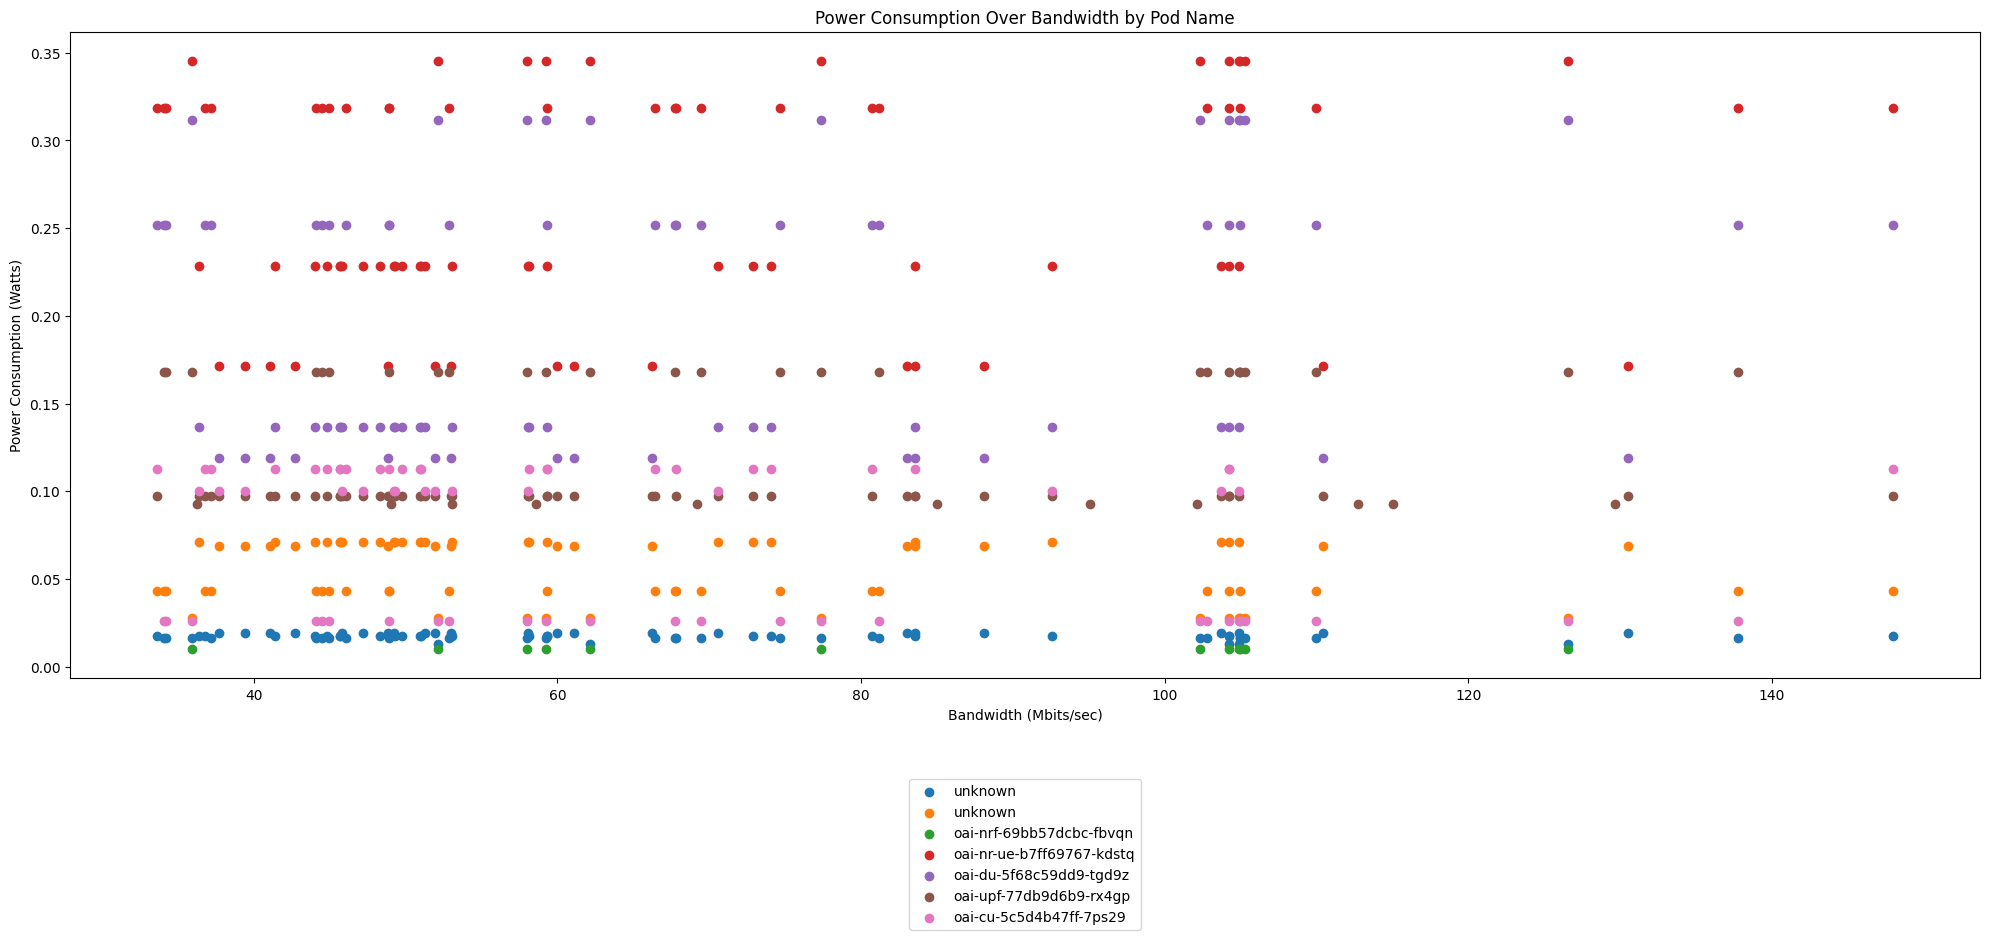

In [38]:
# Load the UID to pod mapping from the CSV file
uid_pod_map = load_uid_pod_map('/home/caterina/ee-5g/plots/uid_pod_mapping.csv')  # Update this path to your actual CSV file

# Plot the metrics
plot_metrics(SAVE_FILE_PATH_DATA, SAVE_FILE_PATH_PLOT, interval=2, uid_pod_map=uid_pod_map, throughput_file="/home/caterina/ee-5g/data/log_oai-upf-77db9d6b9-rpgl8_12.1.1.100_100.csv")